In [5]:
folder = "/media/kakn/storage/prometheus_export/high_v3"

In [6]:
import json, os

values = {}

files = [
    "processor_cpu_full.json",
    "processor_memory_full.json",
    "kafka-0_cpu_full.json",
    "kafka-0_memory_full.json",
    "kafka-1_cpu_full.json",
    "kafka-1_memory_full.json",
    "kafka-2_cpu_full.json",
    "kafka-2_memory_full.json"
    ]

for file in files:
    with open(os.path.join(folder, file), "r") as f:
        values[file] = json.load(f)["data"]["result"][0]["values"]
        values[file] = list(map(lambda x: (x[0], float(x[1])), values[file]))

In [7]:
range_start = 0
range_stop = 0

for i in range(len(values["processor_cpu_full.json"]) - 19 ):
    if all(values["processor_cpu_full.json"][j][1] < 0.5 for j in range(i, i + 20)):
        range_start = values["processor_cpu_full.json"][i][0]
        break

for i in range(len(values["processor_cpu_full.json"]) - 9):
    if all(values["processor_cpu_full.json"][j][1] < 0.02 for j in range(i, i + 10)):
        range_stop = values["processor_cpu_full.json"][i-1][0]
        break

for series in values:
    values[series] = list(filter(lambda x: x[0] >= range_start and x[0] <= range_stop, values[series]))

In [8]:
import numpy as np
import scipy.stats as sp

statistic = {}

for series in values:
    values[series] = np.array(values[series])
    statistic[series] = {
        "mean": np.mean(values[series][:,1]),
        "median": np.median(values[series][:,1]),
        "std": np.std(values[series][:,1]),
        "min": np.min(values[series][:,1]),
        "max": np.max(values[series][:,1]),
        "percentile_95": np.percentile(values[series][:,1], 95),
        "percentile_99": np.percentile(values[series][:,1], 99),
        "percentile_25": np.percentile(values[series][:,1], 25),
        "percentile_75": np.percentile(values[series][:,1], 75),
        "IQR": np.percentile(values[series][:,1], 75) - np.percentile(values[series][:,1], 25),
        "outlier_threshold": np.percentile(values[series][:,1], 75) + 1.5 * (np.percentile(values[series][:,1], 75) - np.percentile(values[series][:,1], 25)),
        "number_of_outliers": len(list(filter(lambda x: x > np.percentile(values[series][:,1], 75) + 1.5 * (np.percentile(values[series][:,1], 75) - np.percentile(values[series][:,1], 25)), values[series][:,1]))),
        "number_of_values": len(values[series][:,1]),
    }

print(json.dumps(statistic, indent=4))

{
    "processor_cpu_full.json": {
        "mean": 0.06681523818605378,
        "median": 0.06592701869771438,
        "std": 0.00869459833661921,
        "min": 0.05025563173353721,
        "max": 0.311922695035435,
        "percentile_95": 0.0781875000000403,
        "percentile_99": 0.08241620242377835,
        "percentile_25": 0.061636442830120826,
        "percentile_75": 0.07140821675360687,
        "IQR": 0.009771773923486042,
        "outlier_threshold": 0.08606587763883593,
        "number_of_outliers": 18,
        "number_of_values": 3794
    },
    "processor_memory_full.json": {
        "mean": 1932643988.079093,
        "median": 1920827392.0,
        "std": 15316515.236112967,
        "min": 1917284352.0,
        "max": 1950994432.0,
        "percentile_95": 1950474240.0,
        "percentile_99": 1950736384.0,
        "percentile_25": 1917353984.0,
        "percentile_75": 1948164096.0,
        "IQR": 30810112.0,
        "outlier_threshold": 1994379264.0,
        "number_

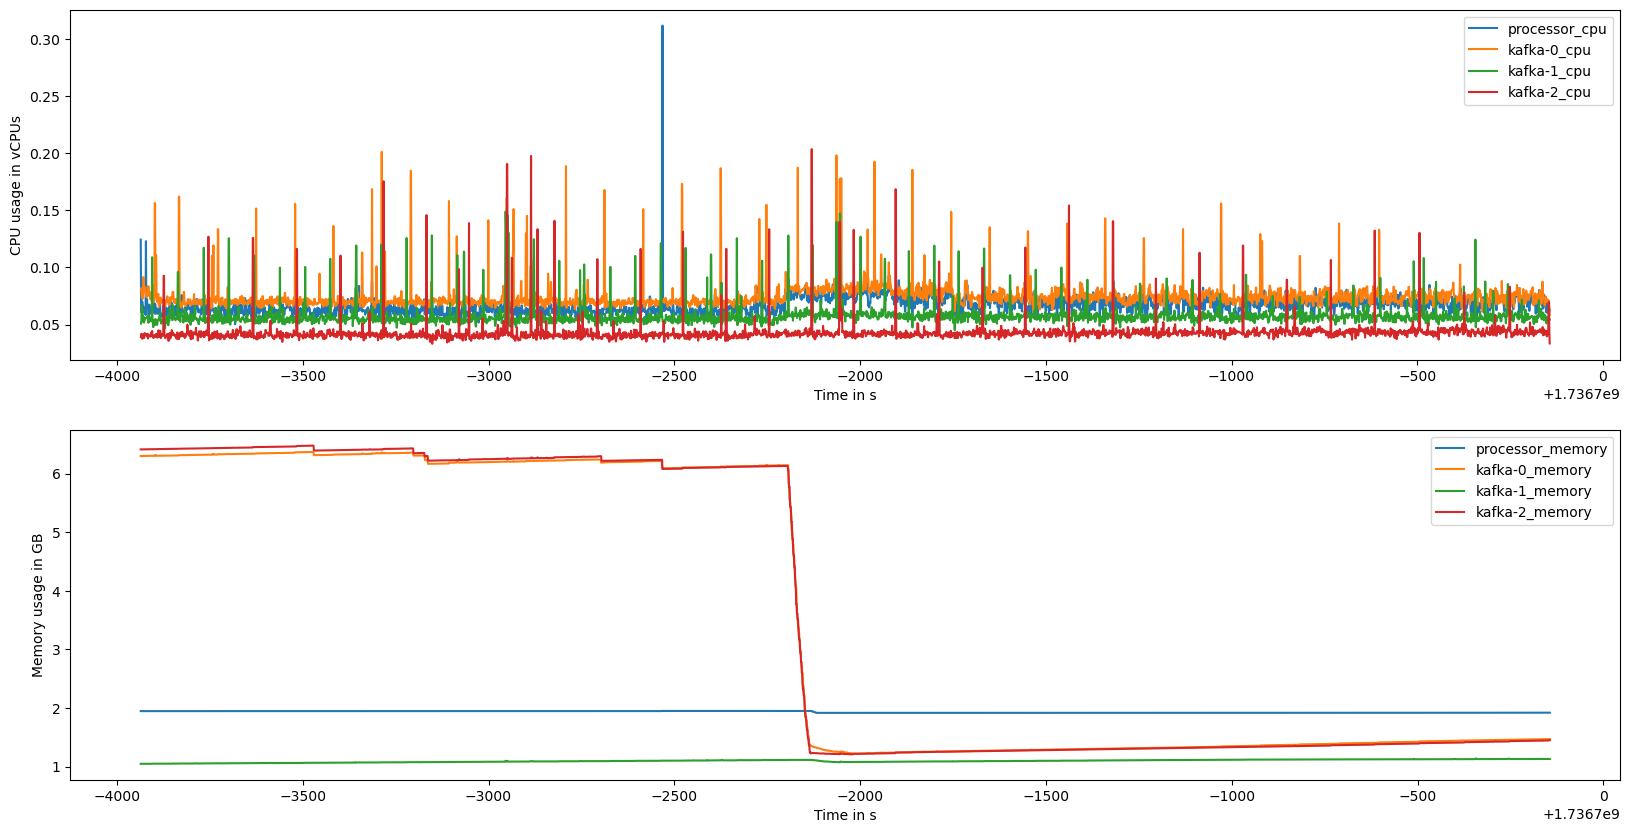

In [9]:
#plot ressource usage of processor and kafka

import matplotlib.pyplot as plt

#umrechnung von byte in gb

GBValues = {}

for series in values:
    if "memory" in series:
        GBValues[series] = np.array(list(map(lambda x: (x[0], x[1] / 1000 / 1000 / 1000), values[series])))

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(values["processor_cpu_full.json"][:,0], values["processor_cpu_full.json"][:,1], label="processor_cpu")
plt.plot(values["kafka-0_cpu_full.json"][:,0], values["kafka-0_cpu_full.json"][:,1], label="kafka-0_cpu")
plt.plot(values["kafka-1_cpu_full.json"][:,0], values["kafka-1_cpu_full.json"][:,1], label="kafka-1_cpu")
plt.plot(values["kafka-2_cpu_full.json"][:,0], values["kafka-2_cpu_full.json"][:,1], label="kafka-2_cpu")
plt.legend()
plt.ylabel("CPU usage in vCPUs")
plt.xlabel("Time in s")
plt.subplot(2, 1, 2)
plt.plot(GBValues["processor_memory_full.json"][:,0], GBValues["processor_memory_full.json"][:,1], label="processor_memory")
plt.plot(GBValues["kafka-0_memory_full.json"][:,0], GBValues["kafka-0_memory_full.json"][:,1], label="kafka-0_memory")
plt.plot(GBValues["kafka-1_memory_full.json"][:,0], GBValues["kafka-1_memory_full.json"][:,1], label="kafka-1_memory")
plt.plot(GBValues["kafka-2_memory_full.json"][:,0], GBValues["kafka-2_memory_full.json"][:,1], label="kafka-2_memory")
plt.ylabel("Memory usage in GB")
plt.xlabel("Time in s")
plt.legend()
plt.show()


In [10]:
print("time_range = [%d,%d]" % (int(range_start * 1000), int(range_stop * 1000)))

time_range = [1736696063705,1736699856705]
